In [92]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import gurobipy as gp
from gurobipy import GRB

In [93]:
# Load in image
image = 'box.csv'
image_data = pd.read_csv(image, header=None).values


In [94]:
# Define parameters
rows, cols = image_data.shape
sigma = 0.05

In [95]:
# Define source and sink pixels - replace for new image
# source_pixel = (0, 0)  # Background, row 1 column A in oval.csv
# sink_pixel = (rows-11, cols-8) # Foreground, row 9 column L in ovalcsv

source_pixel = (0, 0)  # Background, row 1 column A in oval.csv
sink_pixel = (rows-1, cols-1) # Foreground, row 9 column L in ovalcsv

In [96]:
def calculate_similarity(i1, i2):
    return int(np.ceil(100 * np.exp(-((i1 - i2)**2) / (2 * sigma**2))))

### Create the Network Matrix

In [97]:
# Create the network matrix
num_nodes = rows * cols + 2  # +2 for source and sink nodes
network = np.zeros((num_nodes, num_nodes), dtype=int)

In [98]:
# Fill in the network matrix
for i in range(rows): #loop through rows
    for j in range(cols): #loop through columns
        current_node = i * cols + j # get index of current node by converting 2D pixel postition to vertical array
        current_intensity = image_data[i, j] # get intensity of current node
        
        # Connect to right neighbor
        if j < cols - 1: # checks that current pixel is not on far right edge
            right_node = current_node + 1 # get index of right neighbor
            right_intensity = image_data[i, j+1] # get intensity of right neighbor
            similarity = calculate_similarity(current_intensity, right_intensity) # calculate similarity between current node and right neighbor
            network[current_node, right_node] = similarity # add similarity to network
            network[right_node, current_node] = similarity # add similarity to network
        
        # Connect to bottom neighbor
        if i < rows - 1: # check that current pixel is not on the very bottom
            bottom_node = current_node + cols
            bottom_intensity = image_data[i+1, j]
            similarity = calculate_similarity(current_intensity, bottom_intensity)
            network[current_node, bottom_node] = similarity
            network[bottom_node, current_node] = similarity

        # Connect to left neighbor
        if j > 0:  # check that current pixel is not on far left edge
            left_node = current_node - 1
            left_intensity = image_data[i, j-1]
            similarity = calculate_similarity(current_intensity, left_intensity)
            network[current_node, left_node] = similarity
            network[left_node, current_node] = similarity

        # Connect to top neighbor
        if i > 0:  # check that current pixel is not at the very top
            top_node = current_node - cols
            top_intensity = image_data[i-1, j]
            similarity = calculate_similarity(current_intensity, top_intensity)
            network[current_node, top_node] = similarity
            network[top_node, current_node] = similarity

        # Connect to top-left diagonal neighbor
        if i > 0 and j > 0:  # check that top left diagonal neighbor exists in bounds
            top_left_node = current_node - cols - 1
            top_left_intensity = image_data[i - 1, j - 1]
            similarity = calculate_similarity(current_intensity, top_left_intensity)
            network[current_node, top_left_node] = similarity
            network[top_left_node, current_node] = similarity
        
        # Connect to top-right diagonal neighbor
        if i > 0 and j < cols - 1:  # check that top right diagonal neighbor exists in bounds
            top_right_node = current_node - cols + 1
            top_right_intensity = image_data[i - 1, j + 1]
            similarity = calculate_similarity(current_intensity, top_right_intensity)
            network[current_node, top_right_node] = similarity
            network[top_right_node, current_node] = similarity
        
        # Connect to bottom-left diagonal neighbor
        if i < rows - 1 and j > 0:  # check that bottom left diagonal neighbor exists in bounds
            bottom_left_node = current_node + cols - 1
            bottom_left_intensity = image_data[i + 1, j - 1]
            similarity = calculate_similarity(current_intensity, bottom_left_intensity)
            network[current_node, bottom_left_node] = similarity
            network[bottom_left_node, current_node] = similarity
        
        # Connect to bottom-right diagonal neighbor
        if i < rows - 1 and j < cols - 1:  # check that bottom right diagonal neighbor exists in bounds
            bottom_right_node = current_node + cols + 1
            bottom_right_intensity = image_data[i + 1, j + 1]
            similarity = calculate_similarity(current_intensity, bottom_right_intensity)
            network[current_node, bottom_right_node] = similarity
            network[bottom_right_node, current_node] = similarity

In [99]:
# Connect source and sink

source_node = rows * cols # get index of source node
sink_node = rows * cols + 1 # get index of sink node
max_similarity = np.max(network) # get max similarity value in the network

# Convert the x,y coordinates of the source and sink pixel to the index of the network matrix
source_pixel_node = source_pixel[0] * cols + source_pixel[1] 
sink_pixel_node = sink_pixel[0] * cols + sink_pixel[1]

# set connections between source and sink and their pixel nodes to the max similarity value
network[source_node, source_pixel_node] = max_similarity # flow from source node to background pixel only
network[sink_pixel_node, sink_node] = max_similarity # flow from foreground pixel to sink node only

In [100]:
print(network)

[[  0 100   0 ...   0   0   0]
 [100   0 100 ...   0   0   0]
 [  0 100   0 ...   0   0   0]
 ...
 [  0   0   0 ...   0   0 100]
 [100   0   0 ...   0   0   0]
 [  0   0   0 ...   0   0   0]]


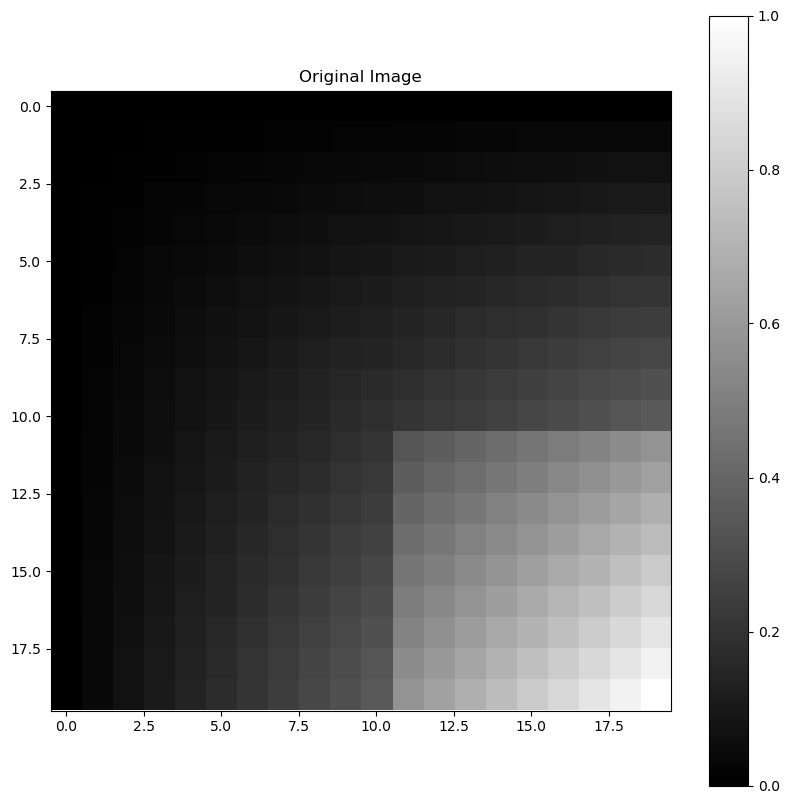

Network shape: (402, 402)
Max similarity: 100


In [101]:
# Visualization of the original image
plt.figure(figsize=(10, 10))
plt.imshow(image_data, cmap='gray')
plt.title('Original Image')
plt.colorbar()
plt.show()

print("Network shape:", network.shape)
print("Max similarity:", max_similarity)